<a href="https://colab.research.google.com/github/gomesluiz/pln-na-pratica/blob/main/u4-02-hands-on-1-classificacao-de-texto-1-commonlit-readability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição da Legibilidade de um Texto
<img src="https://github.com/gomesluiz/commonlit-readability-predicting/blob/main/images/banner_w_border.png?raw=true"
        alt="Banner do projeto"
        width="1020"
        height="300"
        style="display: block; margin: 0 auto" />
<br/>
A legibilidade mede a facilidade com que um leitor pode compreender e assimilar um conteúdo escrito. Essa medida está relacionada à fluidez da leitura e à capacidade do leitor em processar e entender as informações apresentadas. Um texto de alta legibilidade é fácil de ler, compreender e reter, enquanto um texto de baixa legibilidade é mais difícil de ser assimilado.
<br/><br/>
O objetivo deste notebook é mostrar o processo de criação de um modelo de predição de legibilidade de um texto baseado em técnicas de Aprendizado de Máquina (AM) e de Processamento de Linguagem Natural (PLN). Tal modelo poderá ser utilizado para indicar o texto mais apropriado conforme o perfil do leitor e, assim, ajudar a motivar o hábito de leitura.
<br/><br/>


## Pacotes Python
Os seguintes pacotes Python de terceiros são necessários para a execução com sucesso desse notebook:

* [Matplotlib](https://matplotlib.org/): biblioteca para a criação de gráficos e visualizações de dados em geral.
* [NLTK](https://www.nltk.org/): biblioteca para processamento de textos e linguagem natural.
* [Pandas](https://pandas.pydata.org/): biblioteca para análise de dados fornece estruturas flexíveis e eficientes para trabalhar com dados estruturados e tabelas numéricas.
* [Sklearn](https://scikit-learn.org/stable/index.html): biblioteca para tarefas aprendizado de máquina. Fornece uma ampla variedade de algoritmos de aprendizado de máquina supervisionados e não supervisionados.

A forma mais simples para a instalação destas bibliotecas é instalá-las em um ambiente virtual Python. No Linux, essa tarefa pode ser feita assim:

```
~$ cd predicao-de-legibilidade
~/predicao-de-legibilidade$ python -m venv .venv
~/predicao-de-legibilidade$ source .venv/bin/activate
~/predicao-de-legibilidade$ pip install matplotlib nltk pandas sklearn
```

Já no Windows, ela pode ser feita assim:
```
C:\> cd predicao-de-legibilidade
C:\predicao-de-legibilidade> python -m venv .venv
C:\predicao-de-legibilidade> .venv/Scripts/activate.bat
C:\predicao-de-legibilidade> pip install matplotlib nltk pandas sklearn
```

No [Google Colab](https://colab.research.google.com/), todos os pacotes necessários já estão instalado.

In [20]:
!pip install matplotlib nltk pandas scikit-learn

## Metodologia
A metodologia deste projeto está divida nas etapas do processo padrão de mineração de dados denominado Cross Industry Process for Data Mining (CRISP-DM). O modelo CRISP-DM define um conjunto comum de etapas, tarefas e entregáveis necessários para a realização bem-sucedida de um projeto de mineração de dados. Esse modelo é composto por seis etapas principais:
<br/><br/>
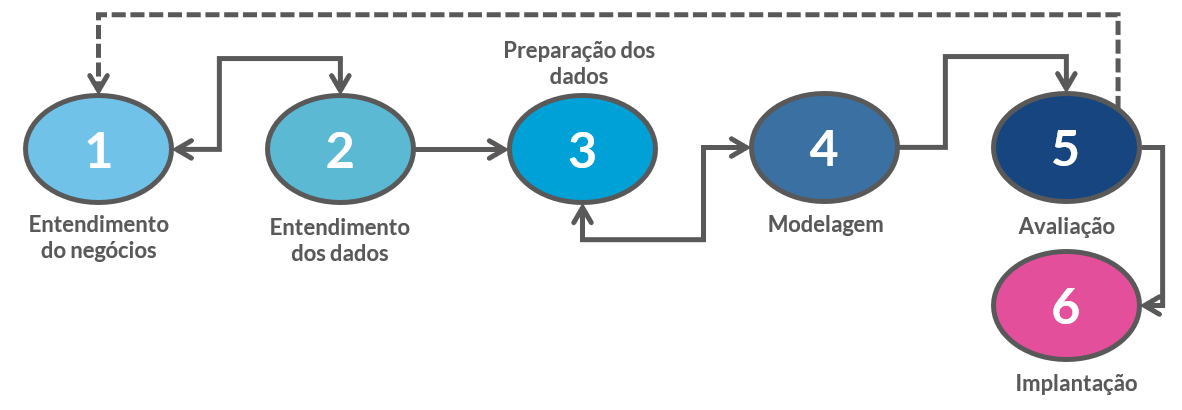

## 1. Entendimento do negócio
Nessa etapa, é necessário entender o problema abordado e as questões relacionadas ele. No contexto deste projeto, a questão primária a ser respondida é

> Por meio das técnicas de Aprendizado de Máquina (AM) e Processamento de Linguagem Natural (PLN), é possível predizer a legibilidade de um texto com uma alta precisão?


## 2. Entendimento dos dados

Nesta etapa, é necessário avaliar os dados disponíveis ou se é necessário coletar dados para responder às perguntas levantadas na etapa de **entendimento do negócio**.
<br/><br/>
O modelo de predição será desenvolvido a partir de uma base de dados utilizada na competição [CommonLit Readability Prize](https://www.kaggle.com/competitions/commonlitreadabilityprize) promovida pela Kaggle  e patrocinada pela empresa [CommonLit, Inc.](https://www.commonlit.org/en); e pelo [Departamento de Linguística da Georgia State University](https://alsl.gsu.edu/).
<br/><br/>
**Descrição da base de dados**

* **id**: Identificador para trecho do texto.
* **url_legal**: URL da fonte do trecho do texto.
* **license**: Licença de uso do trecho do texto.
* **excerpt**: Trecho do texto avaliado.
* **target**: legibilidade do trecho do texto.
* **standard_error**: medida da dispersão das pontuações entre múltiplos avaliadores para cada trecho. Não inclui dados de testes.


### 2.1 Coleta de dados




In [21]:
# Importa o pacote pandas.
import pandas as pd

# Executa o download dos dados de treinamento do modelo. Apenas as colunas
# excerpt e target são lidas.
URL_PATH = "https://raw.githubusercontent.com/gomesluiz/\
commonlit-readability-predicting/main/datasets/train.csv"

trechos  = pd.read_csv(URL_PATH, usecols=["excerpt", "target"])

# Renomeia as colunas do conjunto de dados.
trechos.columns = ["trecho", "legibilidade"]

# Exibe os cinco primeiros registros.
trechos.head()

,trecho,legibilidade
0,When the young people returned to the ballroom...,-0.340259
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372
2,"As Roger had predicted, the snow departed as q...",-0.580118
3,And outside before the palace a great garden w...,-1.054013
4,Once upon a time there were Three Bears who li...,0.247197


## 2.2 Análise exploratória de dados

In [22]:
def conta_palavra(texto):
  """Conta palavras no texto.

  Args:
    texto: O texto a ser processado.

  Returns:
    Contagem de palavras do texto.

  """
  return len(texto.split())

In [23]:
trechos["legibilidade"].describe()

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: legibilidade, dtype: float64

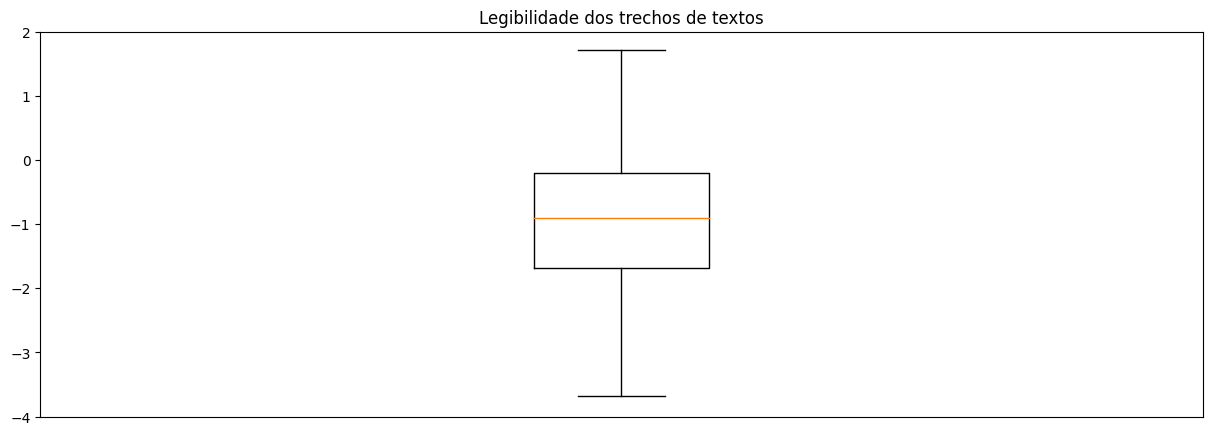

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(15, 5))
_ = plt.boxplot(trechos["legibilidade"])
_ = plt.title("Legibilidade dos trechos de textos")
_ = plt.xticks([], [])
_ = plt.ylim(-4, 2)

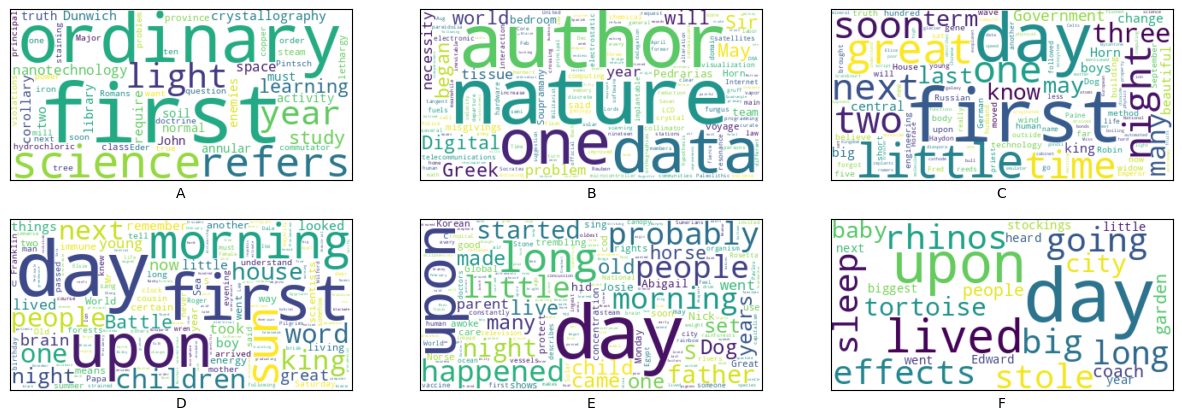

In [26]:
from wordcloud import WordCloud


linhas, colunas = 2, 3
conta_linha, conta_coluna = 0, 0
fig, ax = plt.subplots(linhas, colunas, sharex='col', sharey='row', figsize=(15, 5))

trechos["legibilidade_categoria"] = pd.cut(trechos["legibilidade"], bins=[-4, -3, -2, -1, 0, 1, 2], labels=["A", "B", "C", "D", "E", "F"])
for intervalo in ["A", "B", "C", "D", "E", "F"]:

  textos = trechos[(trechos.legibilidade_categoria == intervalo)].trecho
  words  = " ".join([texto.split()[1] for texto in textos])
  word_cloud = WordCloud(collocations = False, background_color = 'white').generate(words)
  ax[conta_linha, conta_coluna].imshow(word_cloud, interpolation='bilinear')
  ax[conta_linha, conta_coluna].set_xticks(())
  ax[conta_linha, conta_coluna].set_yticks(())
  ax[conta_linha, conta_coluna].set(xlabel=intervalo)

  conta_coluna += 1
  if conta_coluna > 2:
    conta_linha = conta_linha + 1
    conta_coluna = 0

plt.show()

In [27]:
trechos.head()

,trecho,legibilidade,legibilidade_categoria
0,When the young people returned to the ballroom...,-0.340259,D
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,D
2,"As Roger had predicted, the snow departed as q...",-0.580118,D
3,And outside before the palace a great garden w...,-1.054013,C
4,Once upon a time there were Three Bears who li...,0.247197,E


## 3. Preparação de dados
O objetivo desta etapa do CRISP-DM é limpar e transformar os dados em um formato adequado para o treinamento do modelo.


### 3.1. Limpeza de dados

### 3.2. Normalização de dados

### 3.3. Tokenização

### 3.4. Remoção de palavras irrelevantes



In [28]:
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

def preprocessa_texto(texto):
  # remove pontuação do texto.
  # normaliza o texto para minúsculo.
  texto_normalizado = "".join([palavra.lower() for palavra in texto if palavra not in string.punctuation])

  # tokeniza o texto
  texto_tokenizado = nltk.tokenize.word_tokenize(texto_normalizado)

  # remove palavras irrelevantes (stop words)
  texto_sem_stopwords = " ".join([palavra for palavra in texto_tokenizado if palavra not in stopwords])

  return texto_sem_stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# Teste da função preprocessa_texto.
print(f"Texto original:\n{trechos.iloc[0]['trecho']}")
print(f"Texto pré-processado:\n{preprocessa_texto(trechos.iloc[0]['trecho'])}")

Texto original:
When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter, but each traveller was obliged to wear sn

In [30]:
# Pré-processa os trechos de textos.
trechos["trecho_processado"] = trechos["trecho"].apply(preprocessa_texto)
trechos.head()

,trecho,legibilidade,legibilidade_categoria,trecho_processado
0,When the young people returned to the ballroom...,-0.340259,D,young people returned ballroom presented decid...
1,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,D,dinner time mrs fayre somewhat silent eyes res...
2,"As Roger had predicted, the snow departed as q...",-0.580118,D,roger predicted snow departed quickly came two...
3,And outside before the palace a great garden w...,-1.054013,C,outside palace great garden walled round fille...
4,Once upon a time there were Three Bears who li...,0.247197,E,upon time three bears lived together house woo...


### 3.5 Vetorização

In [31]:
# Divide o dataset de trechos de textos em treinamento e teste.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(trechos["trecho_processado"], trechos["legibilidade_categoria"], test_size=.25, random_state=32)

In [45]:
# Vetoriza os conjuntos de treinamento.
from sklearn.feature_extraction.text import CountVectorizer
vetorizador = CountVectorizer(max_features=1000)
X_train_vetorizado = vetorizador.fit_transform(X_train)
X_train_vetorizado = pd.DataFrame(X_train_vetorizado.toarray(), columns=vetorizador.get_feature_names_out())
X_train_vetorizado.index = X_train_vetorizado.index
X_train_vetorizado.head()

,10,ability,able,according,account,acid,across,act,action,active,...,writing,written,wrong,year,years,yellow,yes,yet,york,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# Vetoriza os conjuntos de testes.
X_test_vetorizado = vetorizador.transform(X_test)
X_test_vetorizado = pd.DataFrame(X_test_vetorizado.toarray(), columns=vetorizador.get_feature_names_out())
X_test_vetorizado.index = X_test_vetorizado.index
X_test_vetorizado.head()

,10,ability,able,according,account,acid,across,act,action,active,...,writing,written,wrong,year,years,yellow,yes,yet,york,young
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Treinamento do modelo
O objetivo desta estapa é construir é treinar o modelo resolver o problema de negócio.

In [47]:
# Treina o modelo com o regressor random forest para estabelecimento
# de um baseline.
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
_= clf.fit(X_train_vetorizado, y_train)
print("Modelo baseline treinado.")

Modelo baseline treinado.


## 5. Avaliação do modelo
O objetivo desta etapa é avaliar o desempenho dos modelos de aprendizagem e determinar se eles são adequados para resolver o problema de negócio.


### 5.1 Teste do modelo

In [48]:
y_pred = clf.predict(X_test_vetorizado)

### 5.2 Avaliação dos resultados

In [49]:
from sklearn.metrics import accuracy_score

# Média dos quatrados dos erros.
print("Mean squared error: %.2f" % accuracy_score(y_test, y_pred))

Mean squared error: 0.41


## 6. Implantação do modelo
O objetivo desta etapa é implementar os modelos de mineração de dados escolhidos na fase anterior e integrá-los ao processo de negócio.

In [50]:
import pickle
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
arquivo = f"{timestamp}-modelo_predicao_legibilidade.sav"
pickle.dump(reg, open(arquivo, 'wb'))